# NAME -PARIKSHIT SAHU
## LETSGROWMORE INTERSHIP
### MORE ADVANCED LEVEL 
#### DATASET_LINK --- https://www.kaggle.com/datasets/msambare/fer2013

#### THE AIM OF THIS PROJECT IS TO DETECT MOOD OF THE PERSON AND TO SUGGEST SONG ACCORDINGLY

#### IMPORTING LIBRARIES AND LOADING DATASET

In [2]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.14.0
Num GPUs Available:  0


In [8]:
train_dir = "D:\LETSGROWMORE\MOOD_DETECT\\train\\"
test_dir = "D:\LETSGROWMORE\MOOD_DETECT\\test\\"

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


#### VISUALIZING THE DATA

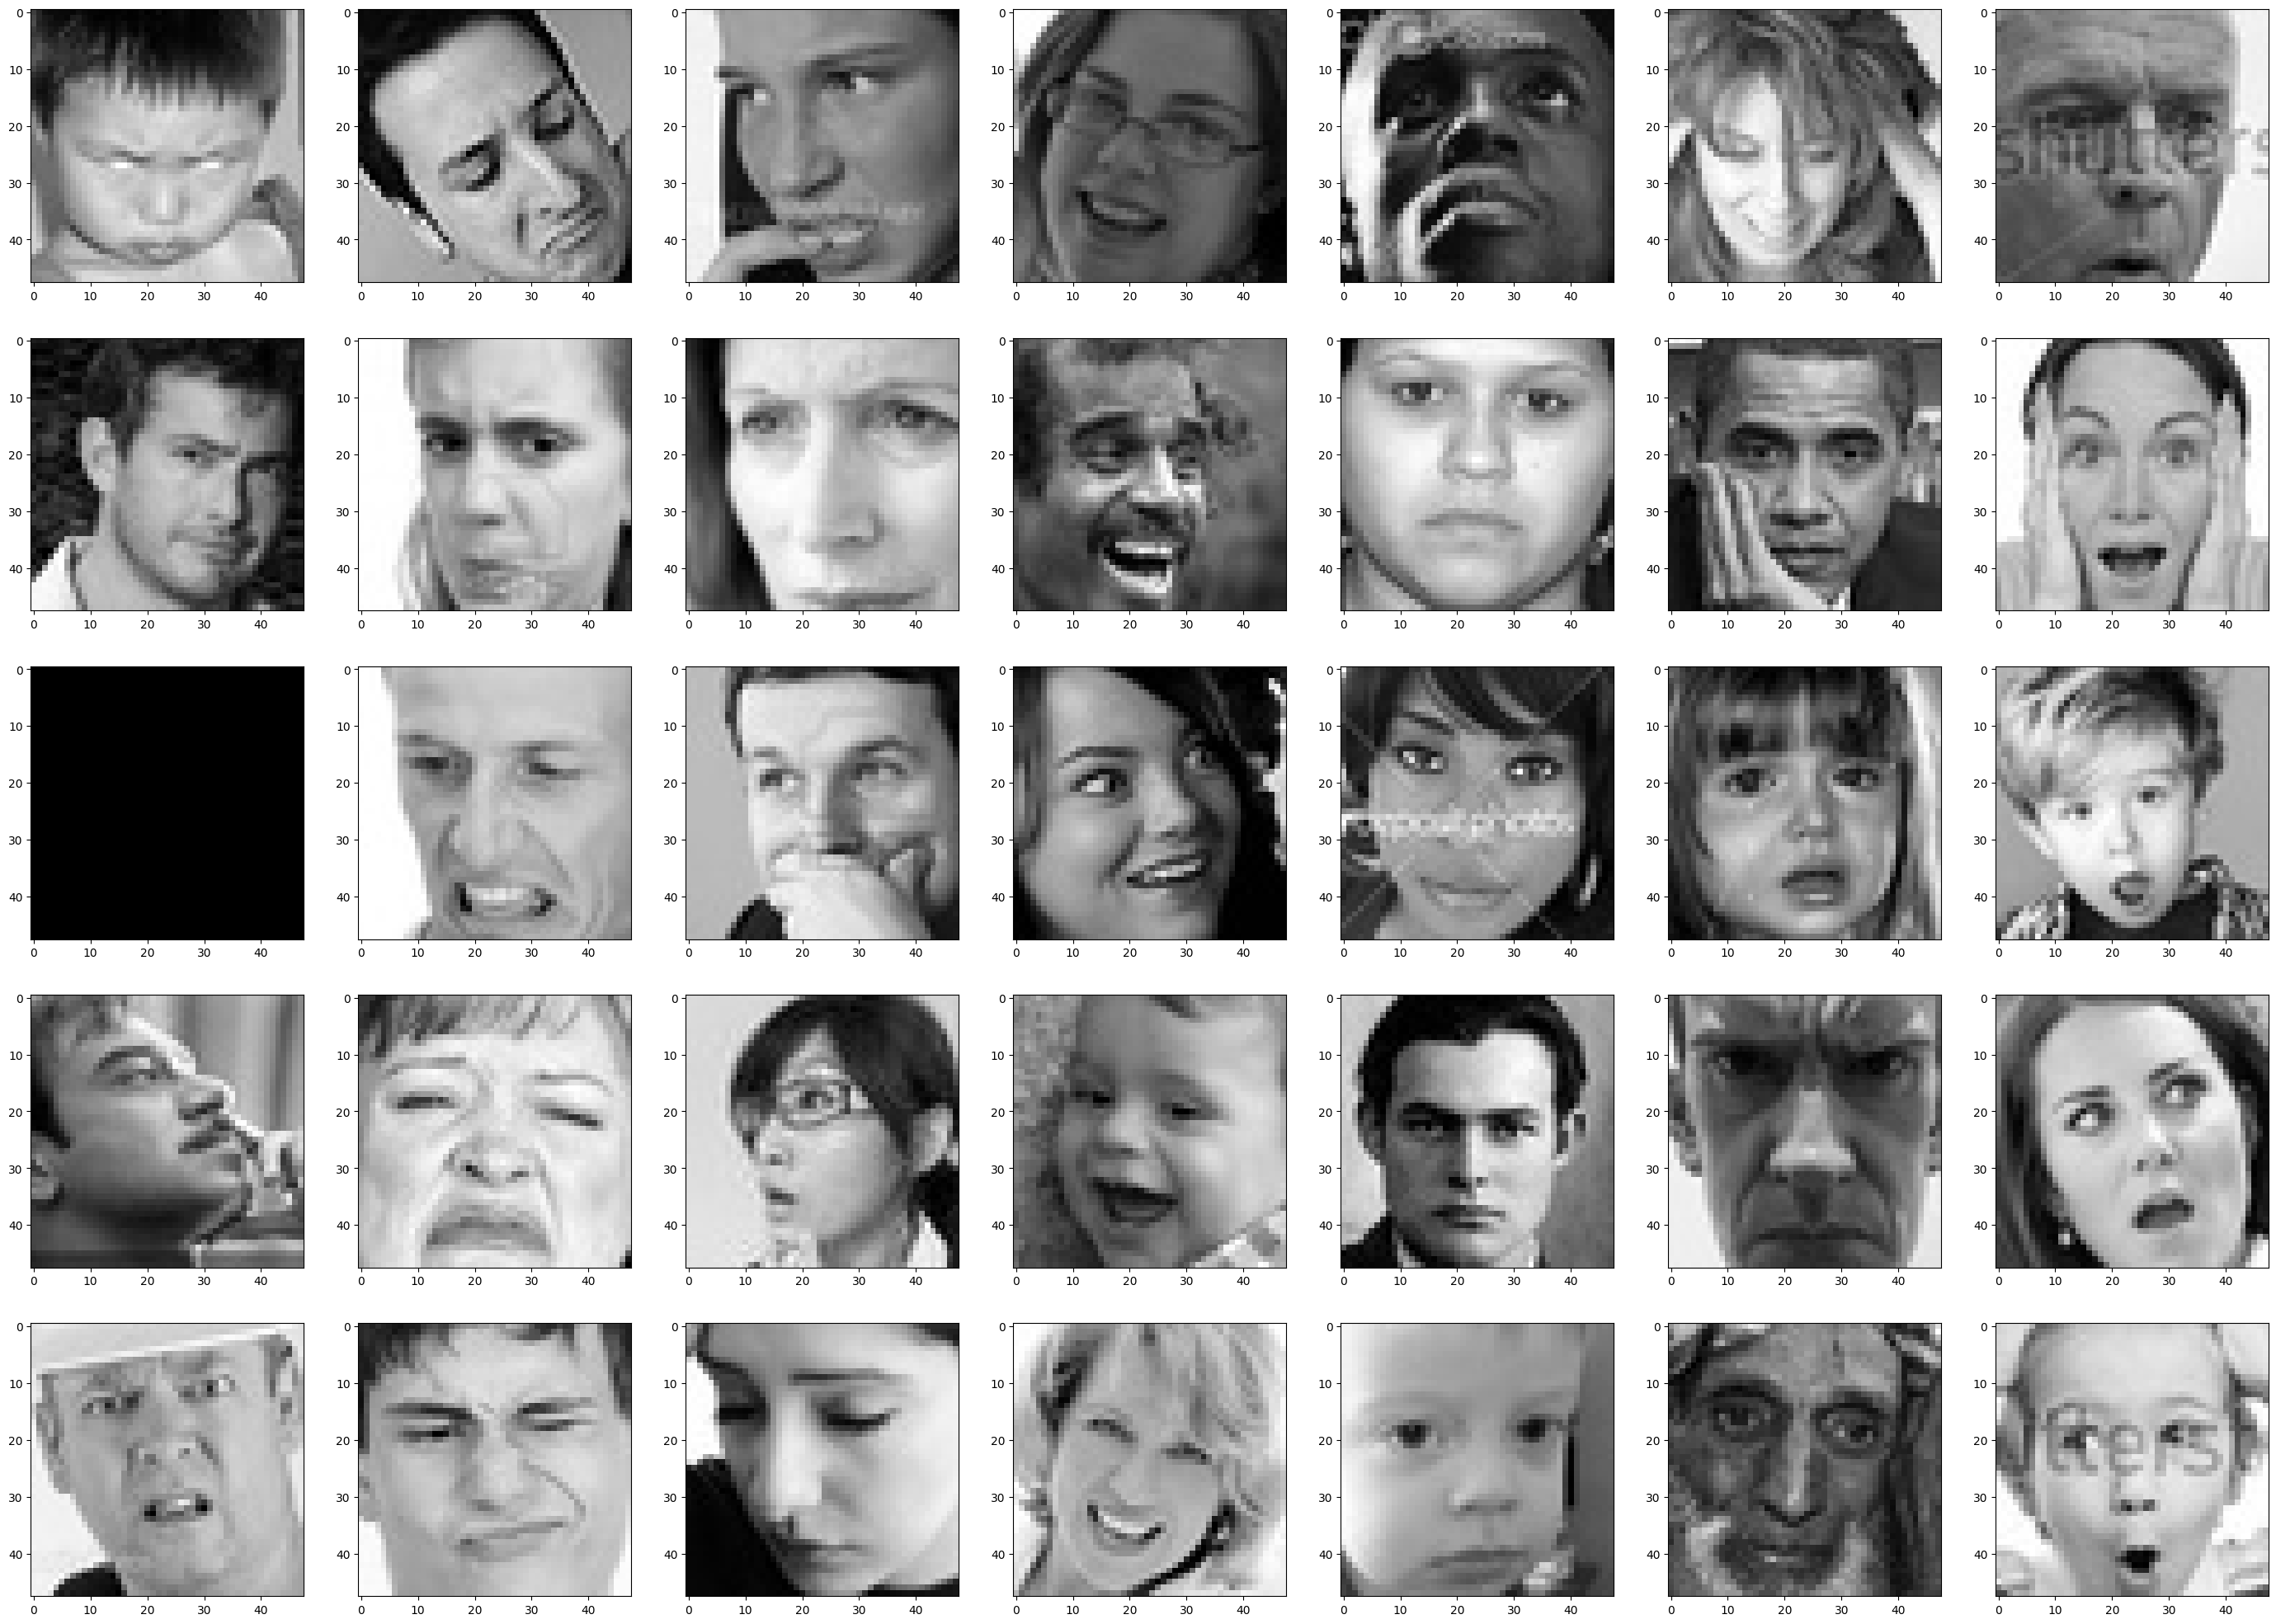

In [9]:
from skimage.io import imread
train_dir = "D:\LETSGROWMORE\MOOD_DETECT\\train\\"
test_dir = "D:\LETSGROWMORE\MOOD_DETECT\\test\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

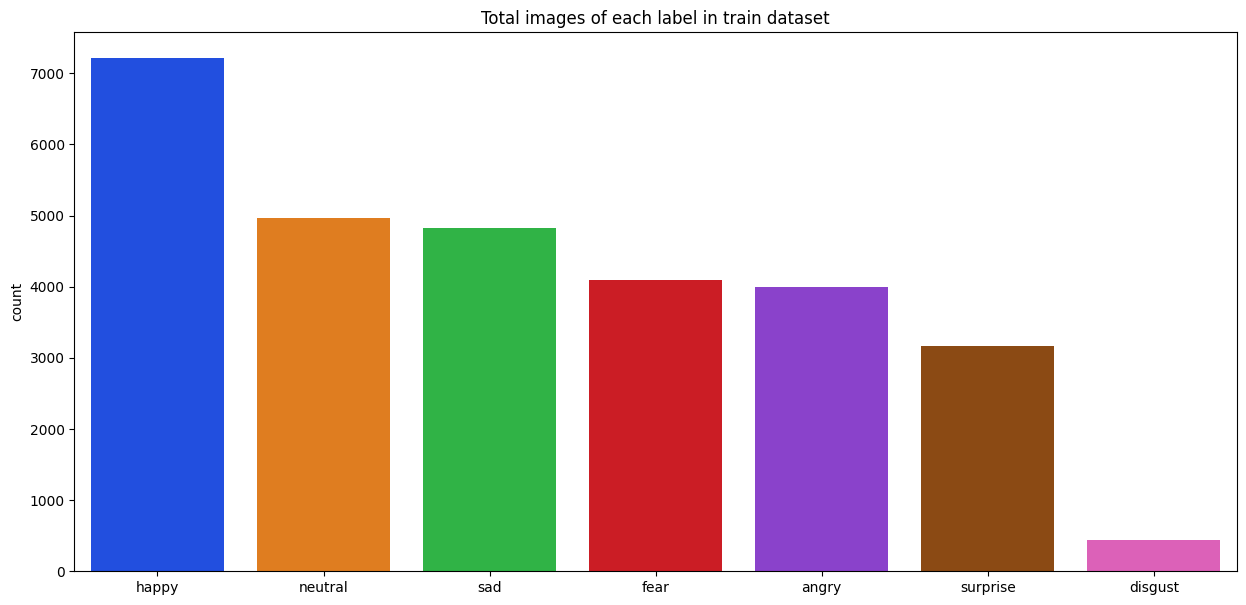

In [11]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="bright", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

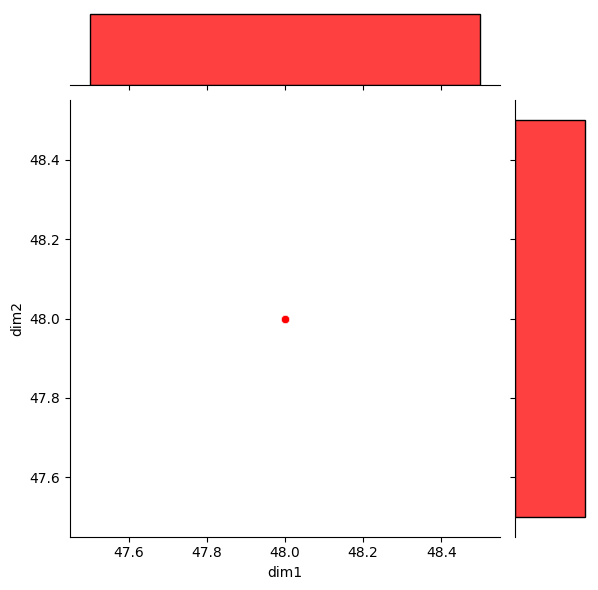

In [14]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

df = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=df, x='dim1', y='dim2', color='r')
plt.show()

#### PREPROCESSING THE DATA AND BUILDING THE MODEL

In [15]:
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

#### TRAINING THE MODEL

In [23]:
tf.keras.optimizers.legacy.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [27]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 736s 2s/step - loss: 1.8801 - accuracy: 0.2297 - val_loss: 2.4363 - val_accuracy: 0.2019
Epoch 2/20
448/448 [==============================] - 685s 2s/step - loss: 1.7992 - accuracy: 0.2467 - val_loss: 1.8537 - val_accuracy: 0.2589
Epoch 3/20
448/448 [==============================] - 803s 2s/step - loss: 1.7847 - accuracy: 0.2603 - val_loss: 1.7581 - val_accuracy: 0.2737
Epoch 4/20
448/448 [==============================] - 696s 2s/step - loss: 1.7739 - accuracy: 0.2685 - val_loss: 1.7676 - val_accuracy: 0.2817
Epoch 5/20
448/448 [==============================] - 476s 1s/step - loss: 1.7552 - accuracy: 0.2782 - val_loss: 1.6895 - val_accuracy: 0.3170
Epoch 6/20
448/448 [==============================] - 587s 1s/step - loss: 1.7341 - accuracy: 0.2900 - val_loss: 1.6163 - val_accuracy: 0.3499
Epoch 7/20
448/448 [==============================] - 578s 1s/step - loss: 1.7029 - accuracy: 0.3116 - val_loss: 1.5995 - val_accuracy: 0.3654

In [29]:
model.save('my_model.keras')

#### EVALUATING THE MODEL

In [30]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 22s 196ms/step - loss: 1.1726 - accuracy: 0.5485
validation accuracy : 54.84814643859863%
validation loss : 1.1725763082504272


#### TRAINING AND VALIDATION

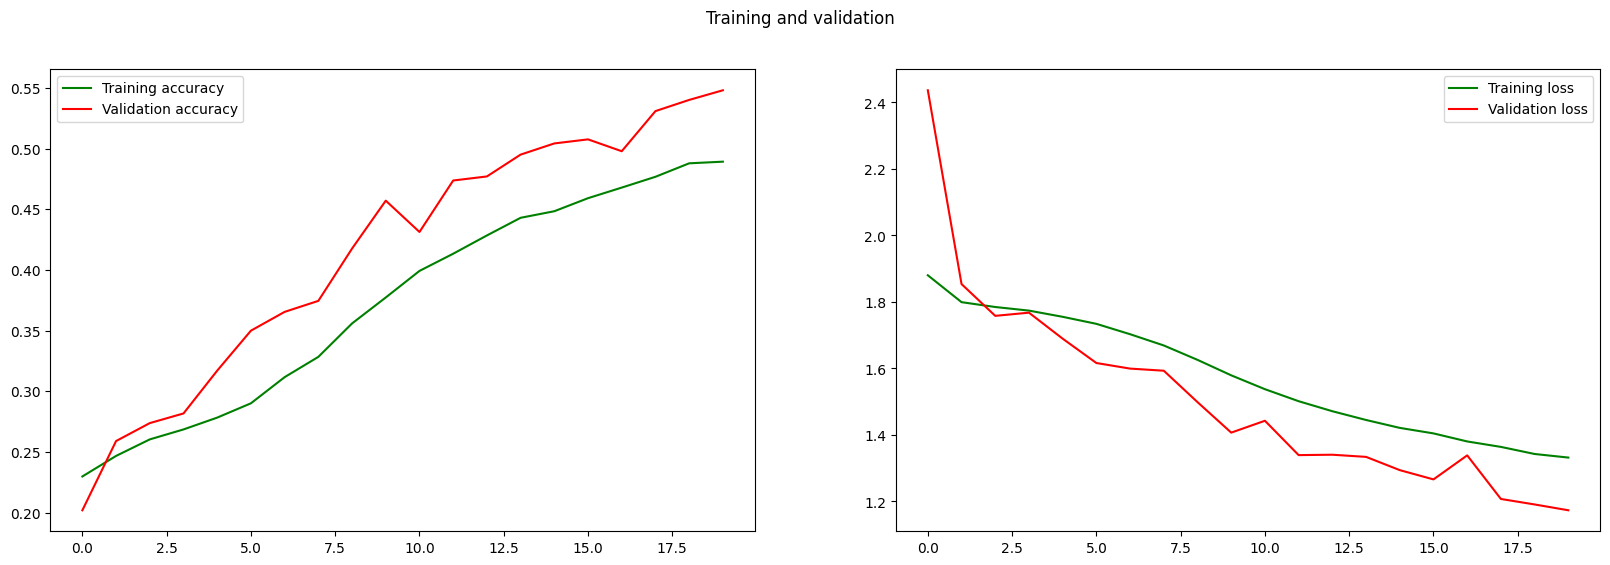

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 24s 207ms/step
              precision    recall  f1-score   support

       angry       0.41      0.52      0.46       958
     disgust       0.42      0.07      0.12       111
        fear       0.41      0.11      0.17      1024
       happy       0.71      0.86      0.78      1774
     neutral       0.44      0.69      0.54      1233
         sad       0.47      0.30      0.36      1247
    surprise       0.68      0.69      0.68       831

    accuracy                           0.55      7178
   macro avg       0.51      0.46      0.45      7178
weighted avg       0.53      0.55      0.52      7178





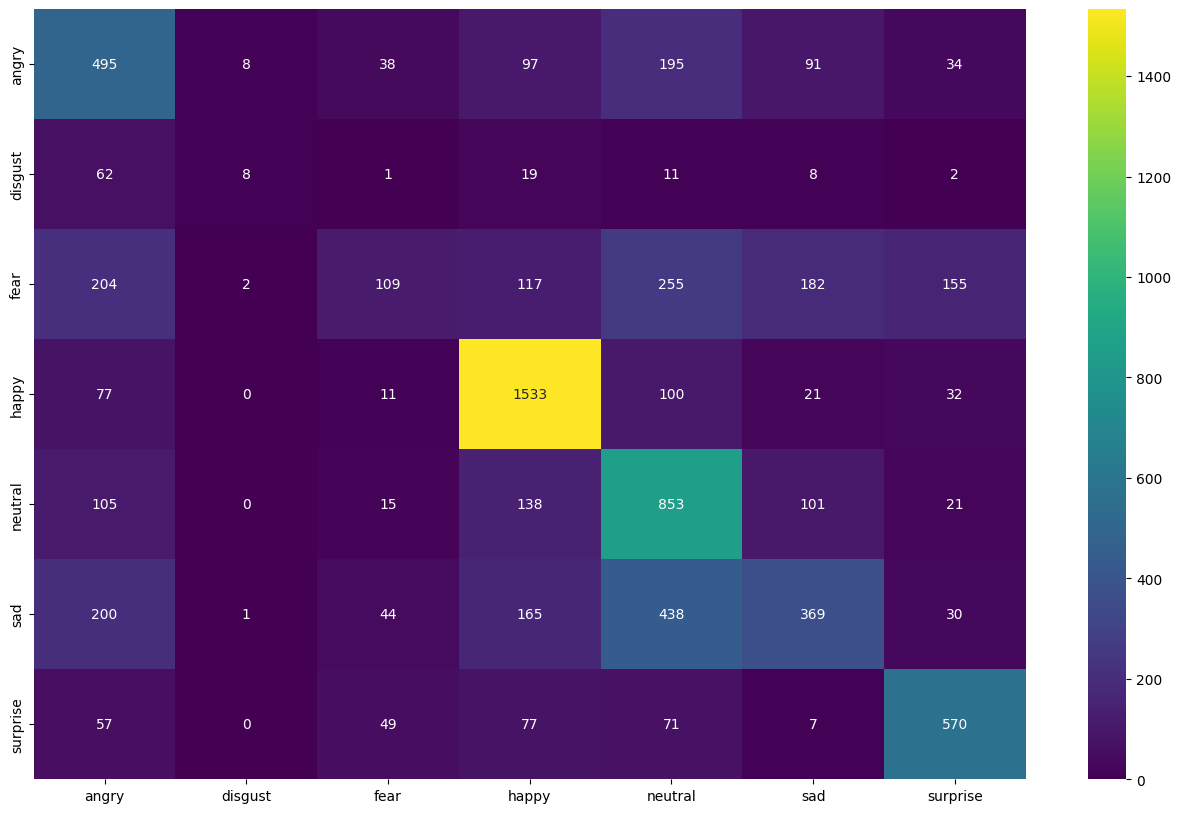

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

#### NOW TESTING THE MODEL

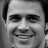

In [34]:
image = cv2.imread(r"D:\LETSGROWMORE\MOOD_DETECT\test\happy\PrivateTest_7438776.jpg")
from IPython.display import Image
Image(filename = r"D:\LETSGROWMORE\MOOD_DETECT\test\happy\PrivateTest_7438776.jpg")

In [35]:
import cv2
from tensorflow.python.keras.models import load_model
import os
model = tf.keras.models.load_model("model.h5",custom_objects={'Functional': tf.keras.models.Model})
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
img = image
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0
gray = gray.reshape(1, 48, 48, 1)
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i, j) in zip(range(7), EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(predictss))
print("\n\n The system considers this expression to be:", label)

1/1 [==============================] - 0s 172ms/step
  Angry    prediction rate is   0.00%
 Disgust   prediction rate is   0.00%
  Happy    prediction rate is   0.00%
   Sad     prediction rate is   1.00%
 Surprise  prediction rate is   0.00%
 Neutral   prediction rate is   0.00%


 The system considers this expression to be: Sad


In [36]:
import random
from IPython.display import Audio, display

if label == 'Angry':
    path = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Angry_song"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Angry_song\\" + d, autoplay=True)
    display(audio)

elif label == 'Disgust':
    path = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Disgusting_songs"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Disgusting_songs\\" + d, autoplay=True)
    display(audio)

elif label == "Happy":
    path = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Happy_songs"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Happy_songs\\" + d, autoplay=True)
    display(audio)

elif label == 'Sad':
    path = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Happy_songs"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Happy_songs\\" + d, autoplay=True)
    display(audio)

elif label == 'Surprise':
    path = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Surprise_song"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Surprise_song\\" + d, autoplay=True)
    display(audio)

elif label == 'Neutral':
    path = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Surprise_song"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename = r"D:\LETSGROWMORE\MOOD_DETECT\Songs\Surprise_song\\" + d, autoplay=True)
    display(audio)


Now Playing: i-dance-when-i-see-you-tropical-house-background-music-for-video-166613.mp3
